# Comparing Data with Syngine Synthetics using ObsPy

### *Demo by Nick Mancinelli, May 2018*

Useful links:
- [Obspy Documentation](https://docs.obspy.org/)
- [Syngine Documentation](http://ds.iris.edu/ds/products/syngine/)


Contents:
- [Part 1: Viewing Seismograms from the Hawaii Earthquake](#Part 1)
- [Part 2: Practical Example 1: *Tuning Deconvolution Parameters*](#Part 2)
- [Part 3: Practical Example 2: *Testing for apparent shear-wave splitting*](#Part 3)

<a id='Part 1'></a>


## Part 1: Viewing Seismograms from the Hawaii Earthquake


### Step 1:  Get event catalog from USGS

- query events from May 1-6, 2018 with Mw >= 5.7
- plot events on the map

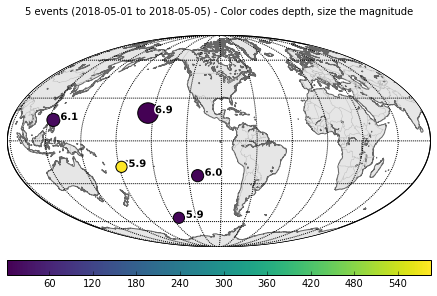

In [1]:
%matplotlib inline
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime

client = Client('USGS')

starttime = UTCDateTime(2018,5,1)
endtime = UTCDateTime(2018,5,7)
minmagnitude = 5.7

cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=minmagnitude)

_ = cat.plot()

### Step 2: Set signal processing workflow
- trim edges
- rotate to ZNE (requires inventory, an obspy class that contains station response info)
- rotate to RT (requires back_azimuth)
- detrend and bandpass filter
- resample

In [2]:
def process_signal(st0, inv, baz):
    st1=st0.copy()
    #trim by 5 sec
    t1=st1[0].stats.starttime+5
    t2=st1[0].stats.endtime-5
    st1.trim(t1,t2)
    st1.rotate('->ZNE',inventory=inv)
    st1.rotate('NE->RT',back_azimuth=baz)
    st1.detrend()
    st1.filter('bandpass', freqmin = 0.005, freqmax =1./10., corners=4, zerophase=True)
    st1.resample(5)
    return(st1)

### Step 3: Get waveforms for Hawaii earthquake
- download data from IRIS
- remove response
- process
- plot

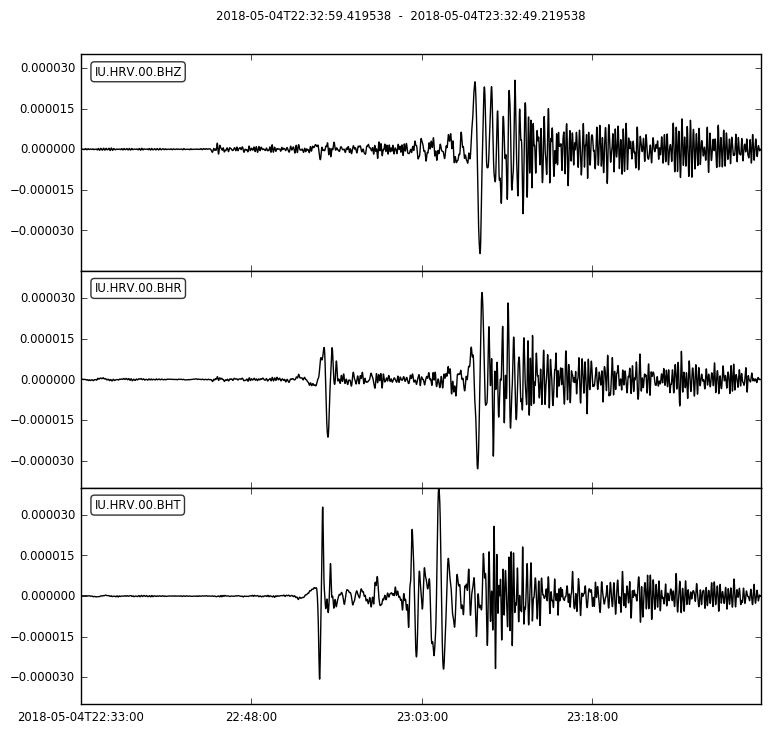

In [3]:
from obspy.geodetics import gps2dist_azimuth

evt = cat[1]
etime, elat, elon = evt.preferred_origin().time, evt.preferred_origin().latitude, evt.preferred_origin().longitude

client = Client("IRIS")

network = 'IU'
station = 'HRV'

inv=client.get_stations(
    starttime=etime,endtime=etime+3600,
    level = "channel", channel="BH*", network=network, station=station)

sta = inv[0][0]

delm, az, baz = gps2dist_azimuth(elat, elon, sta.latitude, sta.longitude)

t1=etime
t2=etime+3600

client = Client('IRIS')

st0=client.get_waveforms(network,station,'00','BH?', t1, t2, attach_response=True)

pre_filt = (0.005, 0.01, 5.0, 10.0)
st0.remove_response(output='DISP', pre_filt=pre_filt)

st1=process_signal(st0, inv = inv, baz = baz)

st1.plot()

### Step 4: Get synthetics for Hawaii earthquake
- Manually input source parameters from [USGS Event Page](https://earthquake.usgs.gov/earthquakes/eventpage/us1000dyad#moment-tensor)
- process
- plot

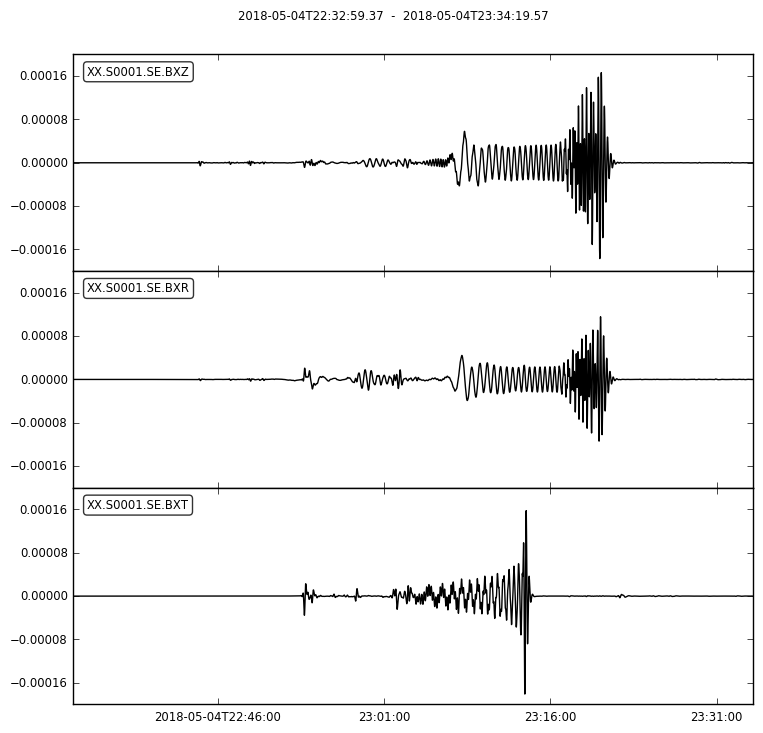

In [4]:
from numpy import arange
from obspy.clients.syngine import Client

elat = evt.preferred_origin().latitude
elon = evt.preferred_origin().longitude
edepth = evt.preferred_origin().depth
etime  = evt.preferred_origin().time

strike = 240
dip = 20
rake= 114
M0 = 2.736e+19

stis = Client().get_waveforms(model="iasp91_2s",
                              sourcelatitude = elat, sourcelongitude = elon,
                              sourcedepthinmeters = edepth,
                              units='displacement',
                              receiverlatitude  = sta.latitude,
                              receiverlongitude = sta.longitude,
                              sourcedoublecouple = [strike, dip, rake, M0],
                              origintime = etime)
    
stis1=process_signal(stis, inv, baz)

stis1.plot()

### Step 5: Compare and plot

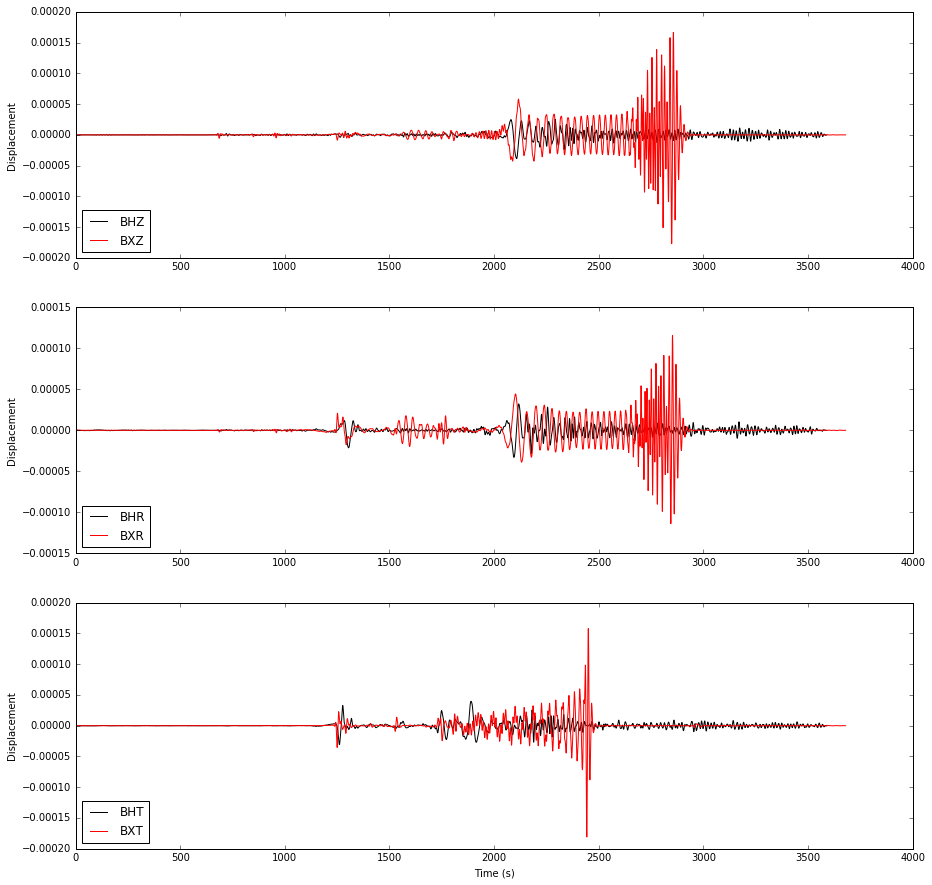

In [5]:
from matplotlib import pylab as plt

def get_index(st,comp):
    for itr, tr in enumerate(st):
        if comp in tr.stats.channel:
            return itr  
    
fig=plt.figure(1,figsize=(15,15))
    
for iplt, comp in enumerate(['Z', 'R', 'T']):
    icomp1 = get_index(st1,comp)
    icomp2 = get_index(stis1,comp)
    
    def plot_trace(trace, color):
        times = arange(len(trace.data)) * trace.stats.delta
        plt.plot(times,trace.data,color,label=trace.stats.channel)
    
    plt.subplot(3,1,iplt+1)
    
    plot_trace(st1  [icomp1],'k')
    plot_trace(stis1[icomp2],'r')
    plt.legend(loc=3)
    plt.ylabel('Displacement')
    
plt.xlabel('Time (s)')

### Other Steps to Consider
 - Convolve traces with source time function









<a id='Part 2'></a>
## Practical Example 1: *Tuning Deconvolution Parameters*

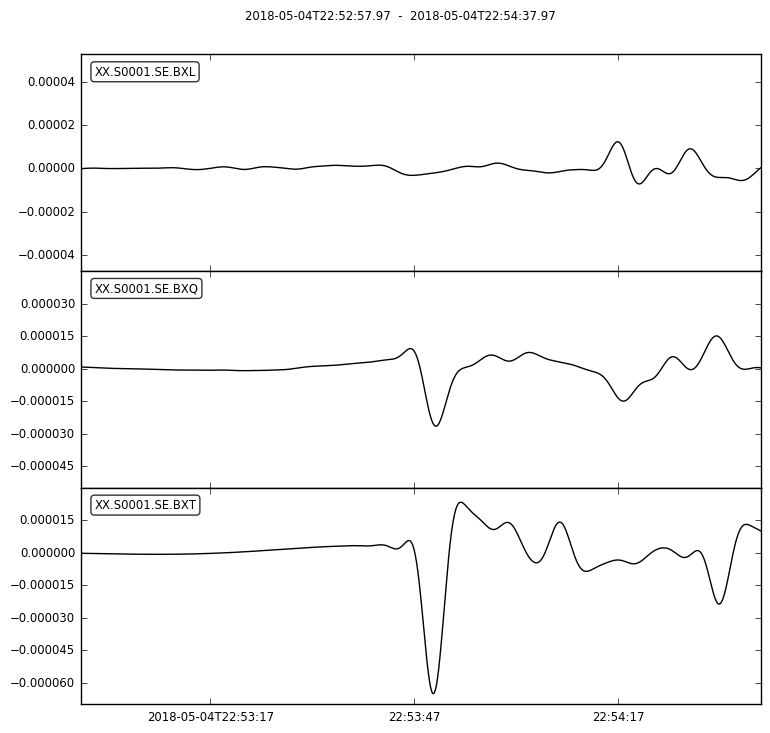

In [6]:
from obspy.taup import TauPyModel

model = TauPyModel('ak135')

arrivals = model.get_travel_times(source_depth_in_km=edepth/1000.0, distance_in_degree=delm/1000./111.11, phase_list = 'S')

assert arrivals[0].phase.name == 'S'

timeS = arrivals[0].time

stis.filter('bandpass', freqmin = 1./50.0, freqmax =1./4., corners=4, zerophase=True)

stis2 = stis.copy().rotate('ZNE->LQT', back_azimuth=baz, inclination = arrivals[0].incident_angle)

stis2.trim(etime+timeS-50, etime+timeS+50).plot()

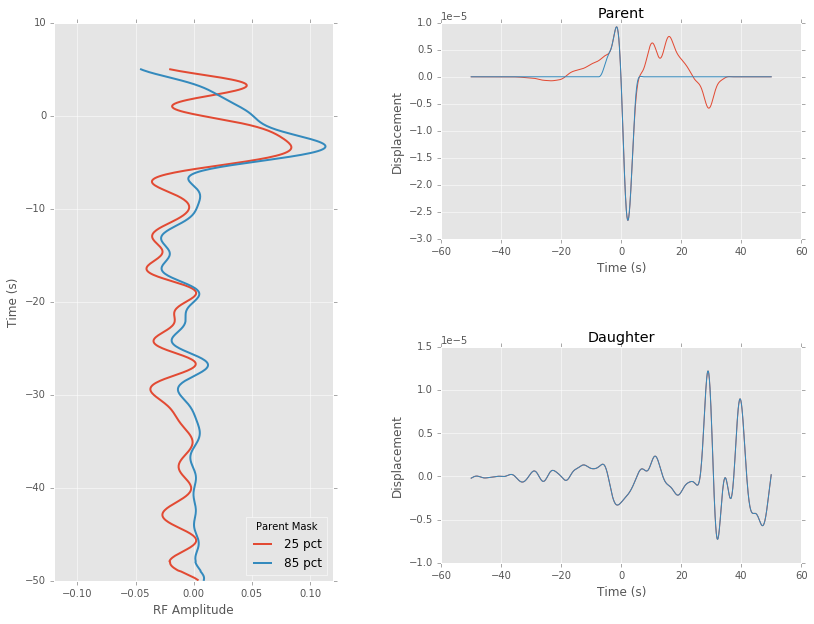

In [7]:
from etmtm import ETMTM
from scipy.signal import tukey
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(1,figsize=(5,10))
plt.style.use('ggplot')


for pctage in [0.25,0.85]:
    assert 'L' in stis2[0].stats.channel
    assert 'Q' in stis2[1].stats.channel

    P = stis2.copy()[1].data
    D = stis2.copy()[0].data
    dt = stis2[0].stats.delta

    #Indeces to mask out

    i1 = int(len(P) * (pctage)/2)
    i2 = int(len(P) - i1)

    P[:i1]=0.0
    P[i2:]=0.0
    P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))

    TB = 1.5
    NT = 2

    Poverlap = 0.99
    win_len  = 100

    #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
    times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
    _, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

    
    norm = max(abs(RFnorm))
    
    plt.subplot(111)
    plt.plot(RF/norm,times,lw=2, label = '%d pct' % (pctage*100) )

    plt.ylabel('Time (s)')
    plt.xlabel('RF Amplitude')
    plt.xlim(-0.12,0.12)

    fig.add_axes([1.2,0.6,1.0,0.3])
    
    tmp = arange(len(P))*dt - 50
    
    def plot_wvfrm(wvfrm,label):
        plt.plot(tmp,wvfrm)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.ylabel('Displacement')
        plt.xlabel('Time (s)')
        plt.title(label)
        
    plot_wvfrm(P,'Parent')

    fig.add_axes([1.2,0.15,1.0,0.3])
    plot_wvfrm(D,'Daughter')
    
plt.subplot(111)
_ = plt.legend(title = 'Parent Mask', loc=4)


### _Take Away: Complicated processing workflows can be fine-tuned and validated with syngine synthetics!_ 

<a id='Part 3'></a>




## Practical Example 2: *Testing for apparent shear-wave splitting*

- bandpass filter
- take derivative to get velocity waveforms
- trim +/- 30 s around S

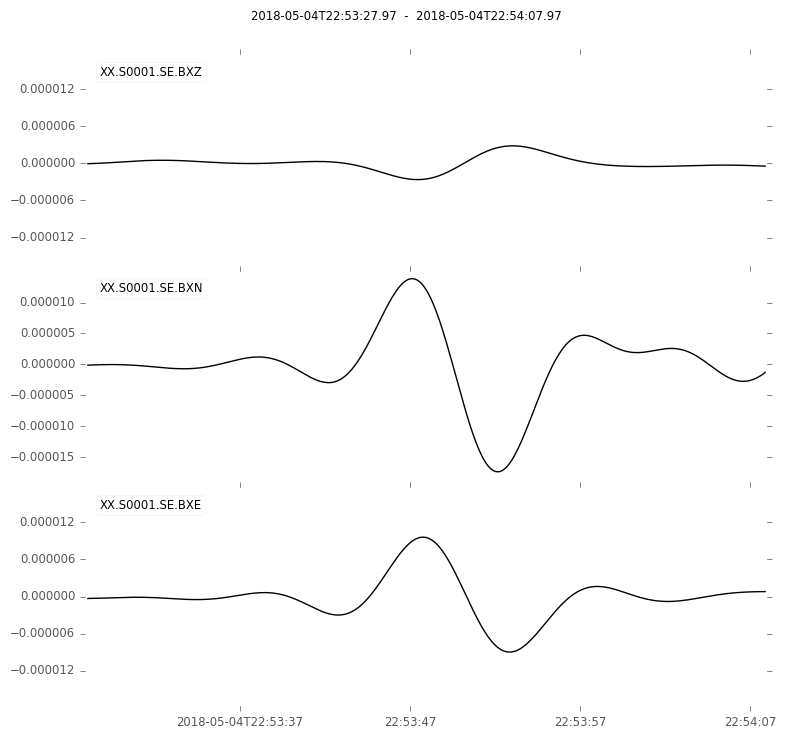

In [8]:
stis3 = stis.copy()
stis3.filter('bandpass', freqmin = 1./50.0, freqmax =1./8., corners=4, zerophase=True).differentiate()

stis3.trim(etime+timeS-20, etime+timeS+20).plot()

### Now plot S particle motion

(-1.9083989516774122e-05, 1.9083989516774122e-05)

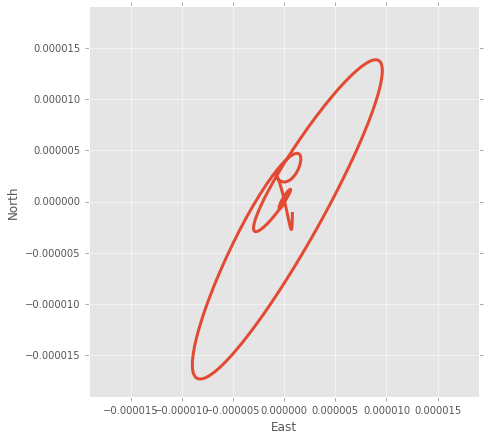

In [9]:
plt.figure(1,figsize=(7,7))
plt.plot(stis3[2].data,stis3[1].data, lw = 3)
plt.xlabel('East')
plt.ylabel('North')
boxlim=max([max(abs(stis3[2].data)), max(abs(stis3[1].data))])*1.1
ax=plt.gca()
ax.set_ylim(-boxlim,+boxlim)
ax.set_xlim(-boxlim,+boxlim)

### Try to linearize particle motion by applying rotations and time shifts

min. lambda 2 = 2.239348e-11


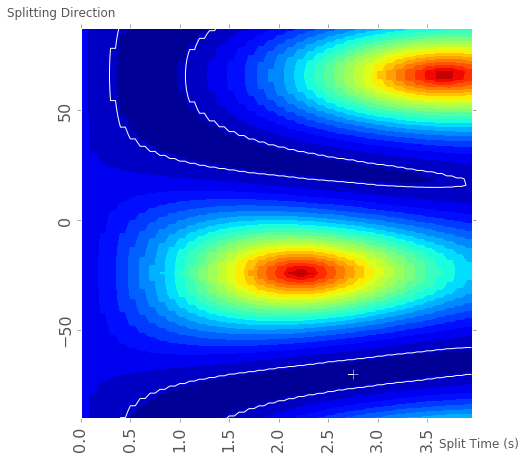

In [10]:
from calculate_split import calculate_split
from numpy import pi


plt.figure(1,figsize=(7,7))
ax=plt.subplot(111)

degrad =  pi / 180.0

calculate_split(stis3[1], stis3[2], az*degrad, plot=True, ax=ax)

for label in ax.get_xticklabels():
    label.set_fontsize(16)
        
for label in ax.get_yticklabels():
    label.set_fontsize(16)
    
plt.ylabel('Splitting Direction', fontsize=12)
plt.xlabel('Split Time (s)', fontsize = 12)

### _This is clearly not a null pattern, but it is unlikely that an analyst would record this as a well-constrained split due to the large error contour._

### _To illustrate a better example of apparent splitting in syngine synthetics, see below._

![Title](figure1-6.png)

### _Take Away: Syngine synthetics empower scientists to check results and test ideas with relative ease._